# Blog Post 6--Fake news classifier

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

import plotly.express as px 
import plotly.io as pio
import pandas as pd
from matplotlib import pyplot as plt
pio.templates.default = "plotly_white"

### Acquire Training Data

In [2]:
# Read csv from url
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
train_org=pd.read_csv(train_url)

In [5]:
train_org.head(5)

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


Drop first column here.

In [6]:
train_org= train_org.iloc[: , 1:]

In [7]:
train_org.head()

,title,text,fake
0,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


### Make a Dataset

First we need to remove stopwords(such as 'and','but', 'the') from `text` and `title`.  

Then we construct the `tf.data.Dataset` with input `(title,text)` and output `fake`.

In [3]:
def make_dataset(data):
    #Import stopwords from package
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    #Remove stopwords from text and title
    data['title']=data['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    data['text']=data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    #construct the Dataset from dictionaries (title:,text:)
    tfdata=tf.data.Dataset.from_tensor_slices(
        ({'title': data['title'],'text':data['text']},
         data['fake']
        )
    )
    tfdata=tfdata.shuffle(buffer_size = len(tfdata))
    #return as batch to imporve the performance
    tfdata=tfdata.batch(100)
    return tfdata

Call the function to make the Dataset from our raw data

In [4]:
tfdata=make_dataset(train_org)

Split 20% of data for validation

In [5]:
train_size=int(0.8*len(tfdata))
val_size=int(0.2*len(tfdata))
train = tfdata.take(train_size)
val   = tfdata.skip(train_size).take(val_size)

In [6]:
len(train),len(val)

(180, 45)

Check the base rate

In [15]:
#The labels_iterator will return 0 or 1 to indicate whether the news is fake
labels_iterator= train.unbatch().map(lambda imput,fake: fake).as_numpy_iterator()
true__freq=0
false_freq=0
for label in labels_iterator:
    if label==0:
        true__freq=true__freq+1
    else:
        false_freq=false_freq+1
print("true__freq = ",true__freq)
print("false_freq = ",false_freq)

true__freq =  8536
false_freq =  9464


Base line is 9511/18000=0.5284

### Create Models

#### Model 1--Title only Model

Below is code for **Text Standardization and Vectorization**.  


Standardization step removes some text like capitals, punctuation, HTML elements or other non-semantic content.  
Vectorization step will reperesent text as a vector

In [9]:
size_vocabulary = 2000
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

In [10]:
vectorize_layer_title = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary,
    output_mode='int',
    output_sequence_length=500)

In [11]:
#vectorize layer
vectorize_layer_title.adapt(train.map(lambda x, y: x['title']))

In [12]:
#Setting title input
title_input=keras.Input(
    shape =(1,),
    name='title',
    dtype='string'
)

Add layers same as lecture notes.

ref: https://nbviewer.org/github/PhilChodrow/PIC16B/blob/master/lectures/tf/tf-4.ipynb

In [20]:
title_features = vectorize_layer_title(title_input)
title_features = layers.Embedding(size_vocabulary, 3, name = "embedding")(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)

In [21]:
title_output = layers.Dense(2,name='fake')(title_features)

Specify the inputs so the model_1 only take `title` column as inputs

In [22]:
model_1 = keras.Model(inputs=title_input,
                      outputs=title_output,
                      name="title_model")

In [23]:
model_1.summary()

Model: "title_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 title (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 3)            6000      
                                                                 
 dropout (Dropout)           (None, 500, 3)            0         
                                                                 
 global_average_pooling1d (G  (None, 3)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 3)                 

In [25]:
model_1.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

Then we train the model_1

In [ ]:
history = model_1.fit(train, 
                    validation_data=val,
                    epochs = 50, 
                    verbose = False)

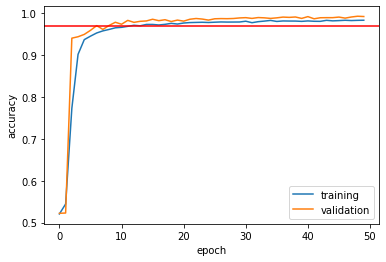

In [137]:
plt.plot(history.history["accuracy"],label = "training")
plt.plot(history.history["val_accuracy"],label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.axhline(y=0.97, color='r', linestyle='-')
plt.legend()

The accuracy of my model 1 stabilized above 97% during training.  
And there's no overfitting.

#### Model_2 -- Text only Model  

Details same as model_1

In [13]:
# Setting for text_input_only
text_input=keras.Input(
    shape =(1,),
    name='text',
    dtype='string'
)
vectorize_layer_text = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, 
    output_mode='int',
    output_sequence_length=250)
vectorize_layer_text.adapt(train.map(lambda x, y: x['text']))
text_features = vectorize_layer_title(text_input)
text_features = layers.Embedding(size_vocabulary, 3, name = "embedding")(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
#A little difference here in order to speed up, since text's size is bigger
text_features = layers.Dense(16, activation='relu')(text_features)
text_output = layers.Dense(2,name='fake')(text_features)

In [28]:
model_2= keras.Model(inputs=text_input,outputs=text_output,name="text_model")

In [29]:
model_2.summary()

Model: "text_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 3)            6000      
                                                                 
 dropout_2 (Dropout)         (None, 500, 3)            0         
                                                                 
 global_average_pooling1d_1   (None, 3)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0

In [30]:
model_2.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [ ]:
history = model_2.fit(train, 
                    validation_data=val,
                    epochs = 20
                      #less epoches for speed
                     )

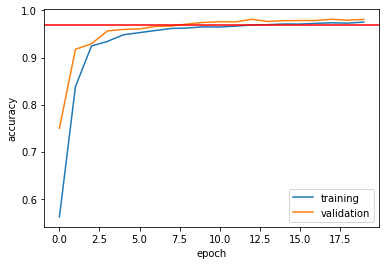

In [158]:
plt.plot(history.history["accuracy"],label = "training")
plt.plot(history.history["val_accuracy"],label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.axhline(y=0.97, color='r', linestyle='-')
plt.legend()

The accuracy of my model 2 stabilized above 97% during training, a little bit worse than model 1.  
And there's no overfitting.

#### Model 3 with both `title` and `text` inputs

Add layers to both inputs

In [14]:
#Same as model 1
title_features = vectorize_layer_title(title_input)
title_features = layers.Embedding(size_vocabulary, 3, name = "embedding_title")(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)

#Same as model 2
text_features = vectorize_layer_title(text_input)
text_features = layers.Embedding(size_vocabulary, 3, name = "embedding_text")(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(16, activation='relu')(text_features)

`Concatenate` the output of `title` pipline with `text` pipline

In [15]:
main = layers.concatenate([title_features, text_features], axis = 1)

In [16]:
main = layers.Dense(32, activation='relu')(main)

In [17]:
#Setting output
output = layers.Dense(2, name = "fake")(main)

In [18]:
model_3 = keras.Model(
    inputs = [title_input, text_input],
    outputs = output
)

In [19]:
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 500)         0           ['title[0][0]',                  
 ization)                                                         'text[0][0]']                   
                                                                                                  
 embedding_title (Embedding)    (None, 500, 3)       6000        ['text_vectorization[1][0]'] 

Use the `plot_model` function to have a better visualization for layers

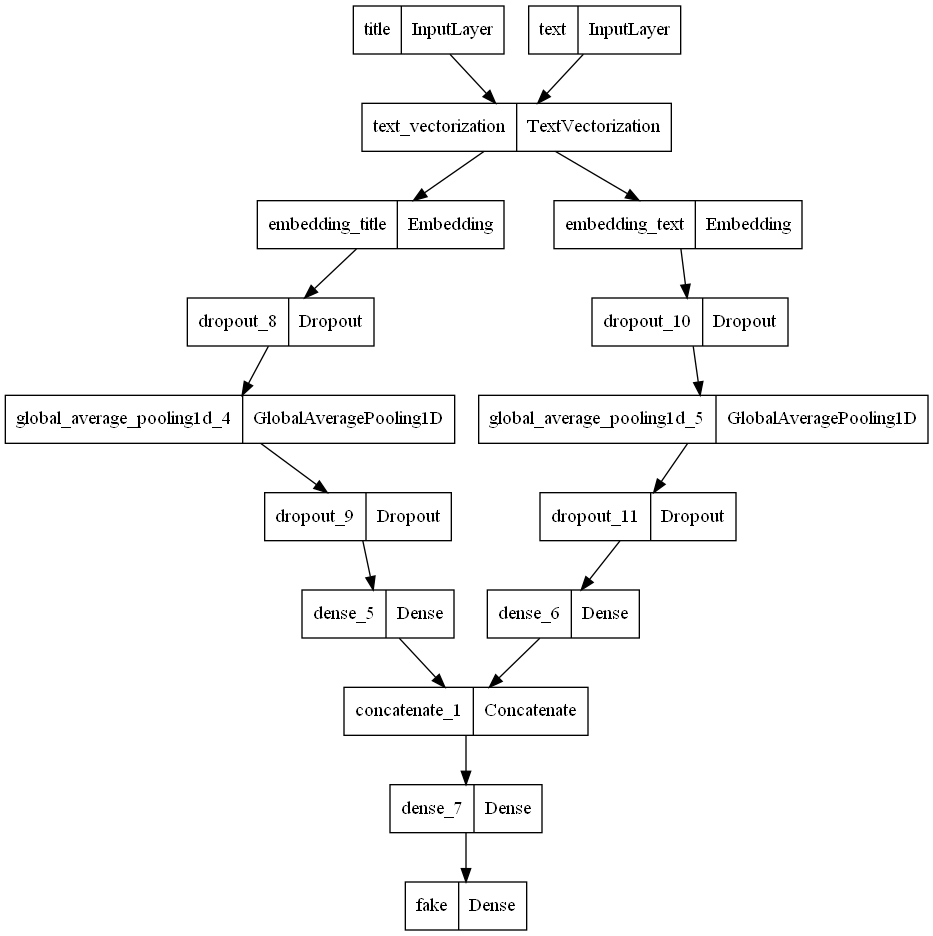

In [42]:
keras.utils.plot_model(model_3)

In [20]:
model_3.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [21]:
history = model_3.fit(train, 
                    validation_data=val,
                    epochs = 30)

Epoch 1/30
180/180 [==============================] - 11s 41ms/step - loss: 0.6425 - accuracy: 0.6344 - val_loss: 0.4419 - val_accuracy: 0.9081
Epoch 2/30
180/180 [==============================] - 7s 40ms/step - loss: 0.2686 - accuracy: 0.9283 - val_loss: 0.1593 - val_accuracy: 0.9575
Epoch 3/30
180/180 [==============================] - 7s 40ms/step - loss: 0.1372 - accuracy: 0.9641 - val_loss: 0.0925 - val_accuracy: 0.9757
Epoch 4/30
180/180 [==============================] - 7s 40ms/step - loss: 0.0831 - accuracy: 0.9775 - val_loss: 0.0575 - val_accuracy: 0.9849
Epoch 5/30
180/180 [==============================] - 7s 40ms/step - loss: 0.0580 - accuracy: 0.9834 - val_loss: 0.0404 - val_accuracy: 0.9879
Epoch 6/30
180/180 [==============================] - 7s 40ms/step - loss: 0.0410 - accuracy: 0.9882 - val_loss: 0.0267 - val_accuracy: 0.9921
Epoch 7/30
180/180 [==============================] - 7s 40ms/step - loss: 0.0306 - accuracy: 0.9909 - val_loss: 0.0278 - val_accuracy: 0.991

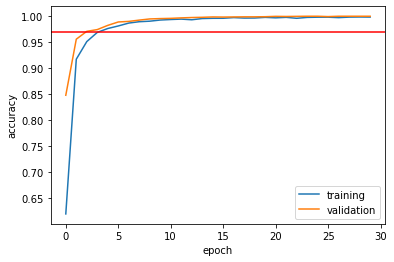

In [45]:
plt.plot(history.history["accuracy"],label = "training")
plt.plot(history.history["val_accuracy"],label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.axhline(y=0.97, color='r', linestyle='-')
plt.legend()

Good news!
The accuracy of my model 3 stabilized very close to 100% during training.  
And there's no overfitting.

## Model Evaluation

In [22]:
#Read the data for testing
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
test_org=pd.read_csv(test_url)
test_org=test_org.iloc[: , 1:]

Use the function `make_dataset` to process our test data

In [23]:
test_data=make_dataset(test_org)

In [50]:
model_3.evaluate(test_data.)

225/225 [==============================] - 3s 11ms/step - loss: 0.0171 - accuracy: 0.9955


[0.0171230249106884, 0.9954563975334167]

The accuracy is 0.9954, which is extremely close to 1!  
GOOD job!

### Embedding Visualization  

Get the weights from both `embedding_title` layer and `embedding_text` layer.  
Since the accuracy of model_1 is higher than model_2, we give `embedding_title` more weight as 0.6, and `embedding_text` with 0.4.

In [60]:
weights = model_3.get_layer('embedding_title').get_weights()[0]*0.6+model_3.get_layer('embedding_text').get_weights()[0]*0.4
weights

array([[ 4.4220760e-03, -3.7515955e-03,  2.9505624e-03],
       [-1.0663554e-01,  2.0389837e-01, -1.8373589e-01],
       [ 1.0753224e-01, -1.6184452e-01, -7.7932082e-02],
       ...,
       [-7.4841455e-02,  1.1953704e-01, -1.2076619e-01],
       [ 4.2736549e-02, -4.0900894e-05,  1.1663854e-02],
       [ 1.8610361e-01, -1.7711309e-01,  1.2361175e-01]], dtype=float32)

In [52]:
# get the vocabulary from our data prep
vocab = vectorize_layer_text.get_vocabulary()

Reduce our data from 3d to a 2d using `PCA`

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

In [54]:
embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})
embedding_df

,word,x0,x1
0,,-0.095760,0.007419
1,[UNK],0.196556,0.034882
2,said,-0.170584,-0.180881
3,trump,2.154822,0.275418
4,the,1.979405,0.249041
...,...,...,...
1995,christians,-0.253563,0.038703
1996,st,-0.023181,0.108869
1997,quoted,0.093434,0.020968
1998,products,-0.118910,-0.002864


In [ ]:
import plotly.express as px 
fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size = list(np.ones(len(embedding_df))),
                 size_max = 2,
                 hover_name = "word")

fig.show()

Embedding finished! 
This embedding is really interesting.   
In the right part **trump, president,obama,election,republican** is close to each other when detecting "fake news".   
And **korea** is close to **missiles**.  
More than that, **women** is close to **power**.    

These words somekind reflect the ralations between each other, the closer group may share some same topics,